In [71]:
import sqlite3

In [72]:
connection = sqlite3.connect('mydb.db')

In [73]:
connection

In [74]:
table_creation_query = """
CREATE TABLE IF NOT EXISTS employees(
    emp_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    hire_date TEXT NOT NULL,
    salary REAL NOT NULL
);
"""

In [75]:
table_creation_query2 = """
CREATE TABLE IF NOT EXISTS customers(
    customer_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    phone TEXT
);
"""

In [76]:
table_creation_query3 = """
CREATE TABLE IF NOT EXISTS orders(
    order_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id INTEGER NOT NULL,
    order_date TEXT NOT NULL,
    amount REAL NOT NULL,
    FOREIGN KEY (customer_id) REFERENCES customers (customer_id)
);
"""

In [77]:
cursor = connection.cursor()

In [78]:
cursor.execute(table_creation_query)
cursor.execute(table_creation_query2)
cursor.execute(table_creation_query3)

In [79]:
insert_query_employees = """
INSERT INTO employees (emp_id, first_name, last_name, email, hire_date, salary)
VALUES (?, ?, ?, ?, ?, ?)
"""

insert_query_customers = """
INSERT INTO customers (customer_id, first_name, last_name, email, phone)
VALUES (?, ?, ?, ?, ?)
"""


insert_query_orders = """
INSERT INTO orders (order_id, customer_id, order_date, amount)
VALUES (?, ?, ?, ?)
"""

In [80]:
employee_data = [
    (1, "employee1", "last1", "employee1@gmail.com", "2021-01-01", 10000.00),
    (2, "employee2", "last2", "employee2@gmail.com", "2022-02-01", 20000.00),
    (3, "employee3", "last3", "employee3@gmail.com", "2023-03-01", 30000.00),
    (4, "employee4", "last4", "employee4@gmail.com", "2024-04-01", 40000.00),
]


customers_data = [
    (1, "king1", "last1", "king1@gmail.com", "112345678"),
    (2, "king2", "last2", "king2@gmail.com", "122345678"),
    (3, "king3", "last3", "king3@gmail.com", "123345678"),
    (4, "king4", "last4", "king4@gmail.com", "123445678"),
    
]


orders_data = [
    (1, 1, "2023-12-01", 250.00),
    (2, 2, "2023-23-01", 150.00),
    (3, 3, "2023-11-01", 300.00),
    (4, 4, "2023-04-03", 450.00),
]

In [81]:
# cursor.executemany(insert_query_employees, employee_data)
# cursor.executemany(insert_query_customers, customers_data)
# cursor.executemany(insert_query_orders, orders_data)

In [82]:
connection.commit()

In [83]:
cursor.execute("select * from orders")

In [84]:
for row in cursor.fetchall():
    print(row)

(1, 1, '2023-12-01', 250.0)
(2, 2, '2023-23-01', 150.0)
(3, 3, '2023-11-01', 300.0)
(4, 4, '2023-04-03', 450.0)


In [85]:
from langchain_community.utilities import SQLDatabase

In [86]:
db = SQLDatabase.from_uri('sqlite:///mydb.db')

In [87]:
db

In [88]:
db.dialect

'sqlite'

In [89]:
db.get_usable_table_names()

['customers', 'employees', 'orders']

In [90]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-70b-8192")

In [91]:
llm.invoke("how are you?").content

"I'm just a language model, so I don't have feelings or emotions like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?"

In [92]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

In [93]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [94]:
tools = toolkit.get_tools()

In [95]:
for tool in tools:
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [96]:
list_tables_tool = next((tool for tool in tools if tool.name=="sql_db_list_tables"), None)

In [97]:
list_tables_tool

ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x75ee753d76d0>)

In [98]:
get_schema_tool = next((tool for tool in tools if tool.name=="sql_db_schema"), None)

In [99]:
get_schema_tool

InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x75ee753d76d0>)

In [100]:
list_tables_tool.invoke("")

'customers, employees, orders'

In [101]:
print(get_schema_tool.invoke("customers"))


CREATE TABLE customers (
	customer_id INTEGER, 
	first_name TEXT NOT NULL, 
	last_name TEXT NOT NULL, 
	email TEXT NOT NULL, 
	phone TEXT, 
	PRIMARY KEY (customer_id), 
	UNIQUE (email)
)

/*
3 rows from customers table:
customer_id	first_name	last_name	email	phone
1	king1	last1	king1@gmail.com	112345678
2	king2	last2	king2@gmail.com	122345678
3	king3	last3	king3@gmail.com	123345678
*/


In [102]:
from langchain_core.tools import tool


@tool
def db_query_tool(query:str)->str:
    """custom db query"""
    result = db.run_no_throw(query)
    if not result:
        return "Error : Query failed. Please rewrite your query and try again."
    return result

In [103]:
db_query_tool.invoke("SELECT * from Employees")

"[(1, 'employee1', 'last1', 'employee1@gmail.com', '2021-01-01', 10000.0), (2, 'employee2', 'last2', 'employee2@gmail.com', '2022-02-01', 20000.0), (3, 'employee3', 'last3', 'employee3@gmail.com', '2023-03-01', 30000.0), (4, 'employee4', 'last4', 'employee4@gmail.com', '2024-04-01', 40000.0)]"

In [104]:
# also do same work
db.run("SELECT * from Employees")

"[(1, 'employee1', 'last1', 'employee1@gmail.com', '2021-01-01', 10000.0), (2, 'employee2', 'last2', 'employee2@gmail.com', '2022-02-01', 20000.0), (3, 'employee3', 'last3', 'employee3@gmail.com', '2023-03-01', 30000.0), (4, 'employee4', 'last4', 'employee4@gmail.com', '2024-04-01', 40000.0)]"

## Query Check
## Query Gen

In [105]:
from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


In [106]:
##Query Check
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SqlLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query.
If there are no mistakes, just reproduce the original query with no further commentary.

Output the final SQL query only."""
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")])

query_check = query_check_prompt | llm.bind_tools([db_query_tool])



In [107]:
query_check.invoke({"messages" : [("user", "SELECT * FROM Employees LIMIT 5;")]})

AIMessage(content='SELECT * FROM Employees LIMIT 5;', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 1007, 'total_tokens': 1016, 'completion_time': 0.001267818, 'prompt_time': 0.081980408, 'queue_time': 0.269232962, 'total_time': 0.083248226}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3cda533f-8db9-4f06-8fbb-76768d553be5-0', usage_metadata={'input_tokens': 1007, 'output_tokens': 9, 'total_tokens': 1016})

In [108]:
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")

# Add a node for a model to generate a query based on the question and schema
query_gen_system_prompt = """You are a SQL expert with a strong attention to detail.Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

1. DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

2. Output the SQL query that answers the input question without a tool call.

3. Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.

4. You can order the results by a relevant column to return the most interesting examples in the database.

5. Never query for all the columns from a specific table, only ask for the relevant columns given the question.

6. If you get an error while executing a query, rewrite the query and try again.

7. If you get an empty result set, you should try to rewrite the query to get a non-empty result set.

8. NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

9. If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

10. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database. Do not return any sql query except answer. """

query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system_prompt), ("placeholder", "{messages}")])

query_gen = query_gen_prompt | llm.bind_tools([SubmitFinalAnswer])

In [109]:
class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

In [110]:
def first_tool_call(state:State):
    return {"messages" : [AIMessage(content="", tool_calls=[{"name" : "sql_db_list_tables", "args":{}, "id" : "tool_abcd123"}])]}

In [111]:
def handle_toos_error(state:State):
    error = state.get("error")
    tool_calls = state['messages'][-1].tool_calls
    return {
        "messages" : [
            ToolMessage(content=f"Error : {repr(error)}\n Please fix your mistake.", tool_call_id=tc["id"],)
            for tc in tool_calls
        ]
    }
    

In [112]:
def create_tool_note_with_fallback(tools:list)->RunnableWithFallbacks[Any, dict]:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_toos_error)], exception_key="error")

In [113]:
def model_check_query(state:State):
    return {"messages" : [query_check.invoke({"messages" : [state['messages'][-1]]})]}

In [114]:
def query_gen_node(state:State):
    message = query_gen.invoke(state)
    print(f"state from generation_query: {state}")

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}

In [115]:
def should_continue(state:State):
    messages = state["messages"]
    last_message = messages[-1]
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

In [125]:
workflow = StateGraph(State)

In [126]:
workflow.add_node("first_tool_call",first_tool_call)
workflow.add_node("list_tables_tool", create_tool_note_with_fallback([list_tables_tool]))
workflow.add_node("get_schema_tool", create_tool_note_with_fallback([get_schema_tool]))
model_get_schema = llm.bind_tools([get_schema_tool])
workflow.add_node("model_get_schema",lambda state: {"messages": [model_get_schema.invoke(state["messages"])],},)
workflow.add_node("query_gen", query_gen_node)
workflow.add_node("correct_query", model_check_query)
workflow.add_node("execute_query", create_tool_note_with_fallback([db_query_tool]))

In [127]:

workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen",should_continue,
                            {END:END,
                            "correct_query":"correct_query"})
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

In [128]:
app = workflow.compile()

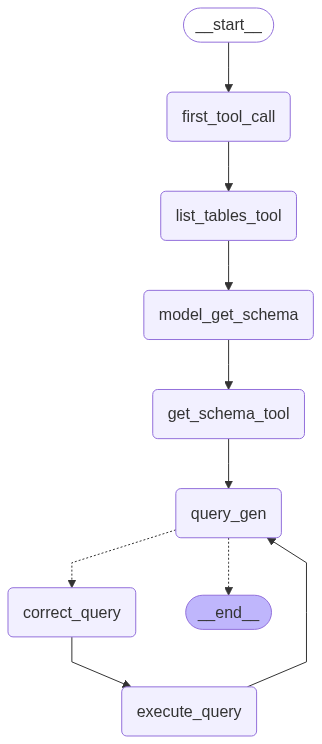

In [129]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [130]:
query={"messages": [("user", "how many order are there which is more than 300 rupees?")]}

In [131]:
response=app.invoke(query)

state from generation_query: {'messages': [HumanMessage(content='how many order are there which is more than 300 rupees?', additional_kwargs={}, response_metadata={}, id='820e6c19-a54b-4f55-b160-8ac291233453'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='fe1e59bd-6a98-44c6-a9fa-f2aa0c213df5', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]), ToolMessage(content='customers, employees, orders', name='sql_db_list_tables', id='bad55af1-6612-48a6-90ef-63aff3b93e81', tool_call_id='tool_abcd123'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'w17h3zp6m', 'function': {'arguments': '{"table_names":"orders"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 1036, 'total_tokens': 1071, 'completion_time': 0.078790406, 'prompt_time': 0.083367454, 'queue_time': 0.267463732, 'total_time': 0.16215786}, 'model_name': 'llama3-70b-819

In [132]:
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

'1'

In [133]:
query={"messages": [("user", "Tell me name of the employee who's salary is more than 30000?")]}
response=app.invoke(query)
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

state from generation_query: {'messages': [HumanMessage(content="Tell me name of the employee who's salary is more than 30000?", additional_kwargs={}, response_metadata={}, id='803c6f95-f314-46ba-9107-93f114bf6683'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='abb0339b-a8d0-4606-bb85-2e5d874f4015', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]), ToolMessage(content='customers, employees, orders', name='sql_db_list_tables', id='da61ff3e-cc6d-410e-9e8d-0fb8f7c78490', tool_call_id='tool_abcd123'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4wgezv39g', 'function': {'arguments': '{"table_names":"employees"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 1038, 'total_tokens': 1073, 'completion_time': 0.077958479, 'prompt_time': 0.083576711, 'queue_time': 0.271015269, 'total_time': 0.16153519}, 'model_name': 'llama

'employee3 last3'